In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils as gutils
import numpy as np
import pandas as pd
import d2lzh as d2l
import matplotlib.pyplot as plt
import time
from mxnet.gluon import rnn, nn

In [2]:
dataset1=pd.read_csv('LSTM迁移后2022年预测结果/calpre/8v2-cal1.csv',header=None)
dataset2=pd.read_csv('LSTM迁移后2022年预测结果/calpre/8v2-cal1.csv',header=None)
dataset3=pd.read_csv('LSTM迁移后2022年预测结果/calpre/8v2-pre1.csv',header=None)
print(dataset1.shape)
print(dataset2.shape)
print(dataset3.shape)

(400, 7)
(400, 7)
(100, 7)


In [3]:
x_train=nd.array(dataset1.iloc[:,:5].values)
y_train=nd.array(dataset1.iloc[:,5].values)# -3为SPAD，-2为含水率，-4为病害程度
x_val=nd.array(dataset2.iloc[:,:5].values)
y_val=nd.array(dataset2.iloc[:,5].values)
x_test=nd.array(dataset3.iloc[:,:5].values)
y_test=nd.array(dataset3.iloc[:,5].values)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(400, 5) (100, 5) (400,) (100,)


In [4]:
cal_features = x_train
val_features = x_val
test_features = x_test
cal_label = y_train
val_label = y_val
test_label = y_test
print(cal_features.shape,cal_label.shape,'\n',
       val_features.shape,val_label.shape,'\n',
       test_features.shape,test_label.shape
      )

(400, 5) (400,) 
 (400, 5) (400,) 
 (100, 5) (100,)


In [5]:
cal_feature = nd.reshape(cal_features, shape=(cal_features.shape[0],1,cal_features.shape[1]))
val_feature = nd.reshape(val_features, shape=(val_features.shape[0],1,val_features.shape[1]))
test_feature = nd.reshape(test_features, shape=(test_features.shape[0],1,test_features.shape[1]))

print(cal_feature.shape,cal_label.shape,'\n',
      val_feature.shape,val_label.shape,'\n',
      test_feature.shape,test_label.shape
     )

(400, 1, 5) (400,) 
 (400, 1, 5) (400,) 
 (100, 1, 5) (100,)


In [6]:
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train_CNN_regress(train_iter, test_iter, net, loss, trainer, ctx, num_epochs,learning_rate, end_con, end_con1):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
        loss_c=train_l_sum / n
        y2preds = []
        y2=[]
        for X, y in test_iter:
            y2preds.extend(net(X.as_in_context(ctx[0])).asnumpy())
            y2.extend(y.asnumpy())
            #break;
        loss_p=np.sum(np.abs((np.array(y2)-np.array(y2preds).reshape(len(y2)))))/len(y2)
        print('epoch %d, loss %.7f,loss %.4f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n,loss_p, 
                 time.time() - start))
        if loss_c<end_con and loss_p<end_con1:break

In [7]:
def train_net(net, learning_rate, num_epochs, end_con, end_con1):
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.L2Loss()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate})
    train_CNN_regress(train_iter, val_iter, net, loss, trainer, ctx, num_epochs, learning_rate, end_con, end_con1)

In [8]:

batch_size=10 #
train_iter = gdata.DataLoader(gdata.ArrayDataset(cal_feature, cal_label), batch_size, shuffle=True)
val_iter  = gdata.DataLoader(gdata.ArrayDataset(val_feature, val_label), batch_size, shuffle=False)
pre_iter  = gdata.DataLoader(gdata.ArrayDataset(test_feature, test_label), batch_size, shuffle=False)
for X, y in train_iter:
    print(X.shape)
    print(y)
    break

ctx = mx.gpu()

(10, 1, 5)

[1.   0.   2.33 1.   0.   1.   0.33 0.33 0.67 0.  ]
<NDArray 10 @cpu(0)>


In [9]:
class Chse1D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super(Chse1D, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)

    def forward(self, x):
        return x * nd.relu(self.weight.data())

In [10]:
# loss = gloss.SoftmaxCrossEntropyLoss()
ctx = mx.gpu(0)

net = nn.Sequential()
net.add(
        Chse1D(5),
        
#         nn.Conv1D(16, kernel_size=3, strides=1),
#         nn.ELU(),
#         nn.MaxPool1D(pool_size=2, strides=2),
#         nn.BatchNorm(),
        
#         nn.Conv1D(16, kernel_size=3, strides=1),
#         nn.ELU(),
#         nn.MaxPool1D(pool_size=2, strides=2),
#         nn.BatchNorm(),
        
#         nn.Conv1D(16, kernel_size=3, strides=1),
#         nn.ELU(),
#         nn.MaxPool1D(pool_size=2, strides=2),
#         nn.BatchNorm(),
        
        
        rnn.LSTM(64, 1, layout="NTC"),
        nn.BatchNorm(axis=1),
        nn.MaxPool1D(pool_size=2, strides=2),
#         rnn.LSTM(64, 1, layout="NTC"
# #                  ,dropout=0.3
#                 ),
#         nn.BatchNorm(axis=1),
        rnn.LSTM(32, 1, layout="NTC"
#                  ,dropout=0.3
                ),
        nn.BatchNorm(axis=1),
#         nn.Dense(512, activation="relu"),nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(128, activation="relu"), nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(16, activation="relu"), nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.01), ctx=ctx,force_reinit=True)
# net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())

In [11]:
print(net[:])

Sequential(
  (0): Chse1D(
  
  )
  (1): LSTM(None -> 64, NTC)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (3): MaxPool1D(size=(2,), stride=(2,), padding=(0,), ceil_mode=False, global_pool=False, pool_type=max, layout=NCW)
  (4): LSTM(None -> 32, NTC)
  (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (6): Dense(None -> 128, Activation(relu))
  (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (8): Dense(None -> 16, Activation(relu))
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): Dense(None -> 1, linear)
)


In [12]:
net[0].initialize(init.Constant(1),force_reinit=True, ctx=ctx)

In [13]:
net.collect_params().reset_ctx(ctx)
net.hybridize()

In [14]:
train_epochs=150
train_lr=0.0001
end_con=0.5
end_con1=0.6
t0=time.time()
train_net(net, train_lr, train_epochs,end_con,end_con1)
time.time()-t0

training on gpu(0)
epoch 1, loss 0.9949324,loss 1.0179, time 0.3 sec
epoch 2, loss 0.9498100,loss 0.9776, time 0.3 sec
epoch 3, loss 0.9041594,loss 1.0996, time 0.3 sec
epoch 4, loss 0.8540308,loss 1.1086, time 0.3 sec
epoch 5, loss 0.8191277,loss 0.8808, time 0.3 sec
epoch 6, loss 0.7901851,loss 0.9311, time 0.3 sec
epoch 7, loss 0.7733269,loss 0.7874, time 0.3 sec
epoch 8, loss 0.7343912,loss 0.9610, time 0.3 sec
epoch 9, loss 0.7078546,loss 1.1834, time 0.3 sec
epoch 10, loss 0.7022517,loss 0.9836, time 0.3 sec
epoch 11, loss 0.6814102,loss 1.4210, time 0.3 sec
epoch 12, loss 0.6515780,loss 0.8967, time 0.3 sec
epoch 13, loss 0.6435022,loss 1.0617, time 0.3 sec
epoch 14, loss 0.6532681,loss 0.6429, time 0.3 sec
epoch 15, loss 0.6544450,loss 0.9677, time 0.3 sec
epoch 16, loss 0.5921013,loss 1.1679, time 0.3 sec
epoch 17, loss 0.5839856,loss 1.2153, time 0.3 sec
epoch 18, loss 0.5748233,loss 1.0433, time 0.3 sec
epoch 19, loss 0.5691045,loss 1.2626, time 0.3 sec
epoch 20, loss 0.5491

8.350335836410522

In [15]:
train_epochs=1500
train_lr=0.00001
end_con=0.45
end_con1=0.55
t0=time.time()
train_net(net, train_lr, train_epochs,end_con,end_con1)
time.time()-t0

training on gpu(0)
epoch 1, loss 0.4862416,loss 0.9611, time 0.4 sec
epoch 2, loss 0.4940532,loss 0.7519, time 0.4 sec
epoch 3, loss 0.4978212,loss 0.9315, time 0.4 sec
epoch 4, loss 0.4894538,loss 0.8083, time 0.4 sec
epoch 5, loss 0.4684721,loss 0.8054, time 0.4 sec
epoch 6, loss 0.4662810,loss 0.7531, time 0.4 sec
epoch 7, loss 0.4750124,loss 0.8326, time 0.4 sec
epoch 8, loss 0.4674459,loss 0.8844, time 0.4 sec
epoch 9, loss 0.4627231,loss 0.7756, time 0.4 sec
epoch 10, loss 0.4437623,loss 0.7655, time 0.4 sec
epoch 11, loss 0.4548350,loss 0.8578, time 0.4 sec
epoch 12, loss 0.4699524,loss 0.7528, time 0.4 sec
epoch 13, loss 0.4822555,loss 0.9091, time 0.4 sec
epoch 14, loss 0.4684857,loss 0.8030, time 0.4 sec
epoch 15, loss 0.4675598,loss 0.8274, time 0.4 sec
epoch 16, loss 0.4566008,loss 0.7910, time 0.4 sec
epoch 17, loss 0.4438974,loss 0.7353, time 0.4 sec
epoch 18, loss 0.4314081,loss 0.8353, time 0.4 sec
epoch 19, loss 0.4561093,loss 0.8742, time 0.4 sec
epoch 20, loss 0.4676

45.893009424209595

In [16]:
train_epochs=150
train_lr=0.00001
end_con=0.4
end_con1=0.5
t0=time.time()
train_net(net, train_lr, train_epochs,end_con,end_con1)
time.time()-t0

training on gpu(0)
epoch 1, loss 0.3522669,loss 0.7988, time 0.4 sec
epoch 2, loss 0.3620885,loss 0.5998, time 0.4 sec
epoch 3, loss 0.3436761,loss 0.7075, time 0.4 sec
epoch 4, loss 0.3388282,loss 0.7204, time 0.4 sec
epoch 5, loss 0.3457178,loss 0.7662, time 0.4 sec
epoch 6, loss 0.3245407,loss 0.8016, time 0.4 sec
epoch 7, loss 0.3206491,loss 0.7786, time 0.4 sec
epoch 8, loss 0.3450601,loss 0.7020, time 0.4 sec
epoch 9, loss 0.3493464,loss 0.6100, time 0.4 sec
epoch 10, loss 0.3432055,loss 0.7273, time 0.5 sec
epoch 11, loss 0.3351570,loss 0.8097, time 0.4 sec
epoch 12, loss 0.3254825,loss 0.6438, time 0.4 sec
epoch 13, loss 0.3370732,loss 0.6412, time 0.4 sec
epoch 14, loss 0.3218750,loss 0.8240, time 0.3 sec
epoch 15, loss 0.3354937,loss 0.6782, time 0.3 sec
epoch 16, loss 0.3226148,loss 0.6855, time 0.4 sec
epoch 17, loss 0.3408984,loss 0.7865, time 0.4 sec
epoch 18, loss 0.3116327,loss 0.6475, time 0.4 sec
epoch 19, loss 0.3398367,loss 0.6108, time 0.4 sec
epoch 20, loss 0.3162

9.377505540847778

In [ ]:
# data = pd.DataFrame(zz)
# data.to_csv('Selection_weight.csv',header=None,index=None)

In [17]:
def ML_perf(yc,y_r,yp,y_rp,str_n):
    plt.figure()
    RMSEC=np.sqrt(np.mean((yc-y_r)**2))
    R2C=1-(np.sum((yc-y_r)**2))/(np.sum((yc-np.mean(yc))**2))
    RPDC=np.std(yc)/RMSEC

    plt.scatter(yc,y_r,c='g',zorder=1,edgecolors=(0, 0, 0))
    plt.plot([0,6],[0,6],'r')

    plt.xlabel('Measured value (%)')
    plt.ylabel('Predicted value (%)')
    plt.title(str_n + ' (RMSEC: %.5f, R2C: %.5f, RPDC: %.5f)' % (RMSEC, R2C, RPDC))
    plt.show()

    plt.figure()
    RMSEP=np.sqrt(np.mean((yp-y_rp)**2))
    R2P=1-(np.sum((yp-y_rp)**2))/(np.sum((yp-np.mean(yp))**2))
    RPDP=np.std(yp)/RMSEP

    plt.scatter(yp,y_rp,zorder=1,edgecolors=(0, 0, 0))
    plt.plot([0,6],[0,6],'r')

    plt.xlabel('Measured value (%)')
    plt.ylabel('Predicted value (%)')
    plt.title(str_n + ' (RMSEP: %.5f, R2P: %.5f, RPDP: %.5f)' % (RMSEP, R2P, RPDP))
    plt.show()

CNN prediction for 400 C inputs in 0.28697 s
CNN prediction for 400 C inputs in 0.06386 s


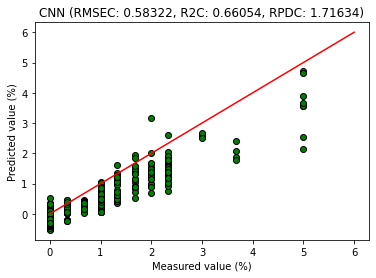

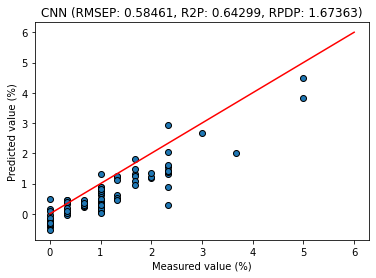

In [18]:
batch_size=5
Xc = cal_feature.asnumpy()
yc = cal_label.asnumpy()
Xp = test_feature.asnumpy()
yp = test_label.asnumpy()
train_iter = gdata.DataLoader(gdata.ArrayDataset(cal_feature, cal_label), batch_size, shuffle=False)
pre_iter  = gdata.DataLoader(gdata.ArrayDataset(test_feature, test_label), batch_size, shuffle=False)
ypreds = []
y0=[]
t0 = time.time()
for X, y in train_iter:
    ypreds.extend(net(X.as_in_context(ctx)).asnumpy())
    y0.extend(y.asnumpy())
cnn_tc = time.time() - t0 
print("CNN prediction for %d C inputs in %.5f s" % (Xc.shape[0], cnn_tc))
y2preds = []
y2=[]
t0 = time.time()
for X, y in pre_iter:
    y2preds.extend(net(X.as_in_context(ctx)).asnumpy())
    y2.extend(y.asnumpy())
cnn_tp = time.time() - t0 
print("CNN prediction for %d C inputs in %.5f s" % (Xc.shape[0], cnn_tp))

ypreds=np.array(ypreds).reshape(yc.shape)
y2preds=np.array(y2preds).reshape(yp.shape)

ML_perf(yc,ypreds,yp,y2preds,'CNN')

In [ ]:
F=np.array([yc,ypreds])
data = pd.DataFrame(F)
data.to_csv('2021model-transfer-9v1-cal-predictdata.csv',index=None,header=None)

In [ ]:
F=np.array([yp,y2preds])
data = pd.DataFrame(F)
data.to_csv('2021model-transfer-9v1-pre-predictdata.csv',index=None,header=None)